In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
sns.set(style='darkgrid', font_scale=1.2)

Loading and Preprocessing Dataset

In [ ]:
image_size = 64
batch_size = 128
mean = (0.5,)
std = (0.5,)
stats = (mean, std)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.Normalize(*stats)]
)

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 78442518.13it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29196359.08it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33803167.25it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6331182.71it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_dl = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

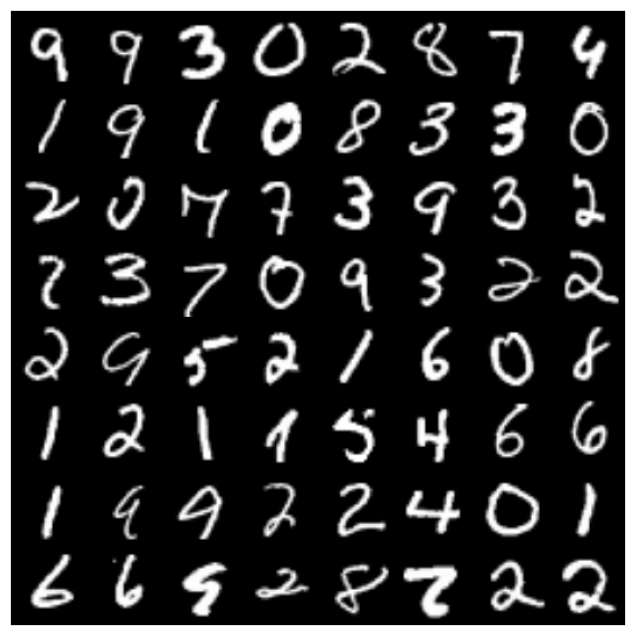

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator Network

In [ ]:
latent_size = 128

In [ ]:
discriminator = nn.Sequential(
    # in: 1 x 64 x 64 (for grayscale images)
    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

Generator Network

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 64 x 64
)

torch.Size([128, 1, 64, 64])


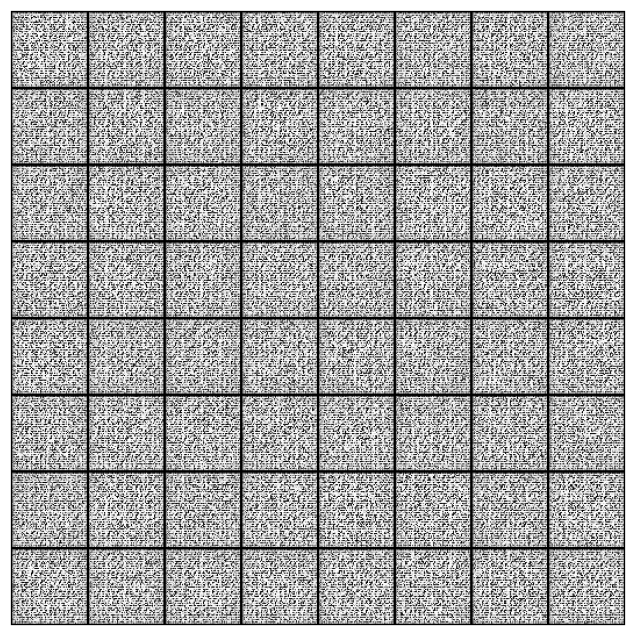

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Training the Network

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 15

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 8.1634, loss_d: 0.0655, real_score: 0.9913, fake_score: 0.0150


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 8.1318, loss_d: 0.0006, real_score: 0.9998, fake_score: 0.0004


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 8.9019, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0002


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 9.9122, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 10.8184, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 11.1069, loss_d: 0.0412, real_score: 0.9937, fake_score: 0.0055


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 3.4224, loss_d: 0.5808, real_score: 0.8256, fake_score: 0.1800


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 2.4743, loss_d: 0.6244, real_score: 0.7965, fake_score: 0.2022


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 2.8519, loss_d: 0.5021, real_score: 0.8405, fake_score: 0.1588


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 3.2566, loss_d: 0.4094, real_score: 0.8671, fake_score: 0.1330


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 2.8956, loss_d: 0.5570, real_score: 0.8282, fake_score: 0.1705


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 3.1195, loss_d: 0.5325, real_score: 0.8334, fake_score: 0.1663


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 3.5127, loss_d: 0.3924, real_score: 0.8811, fake_score: 0.1189


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 3.4509, loss_d: 0.4557, real_score: 0.8673, fake_score: 0.1330


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 4.1270, loss_d: 0.3075, real_score: 0.9136, fake_score: 0.0848
Saving generated-images-0015.png


Loss Function

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

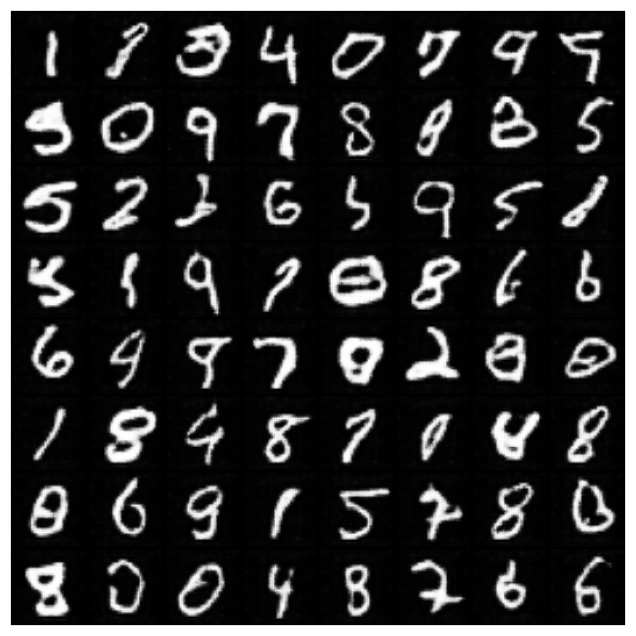

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

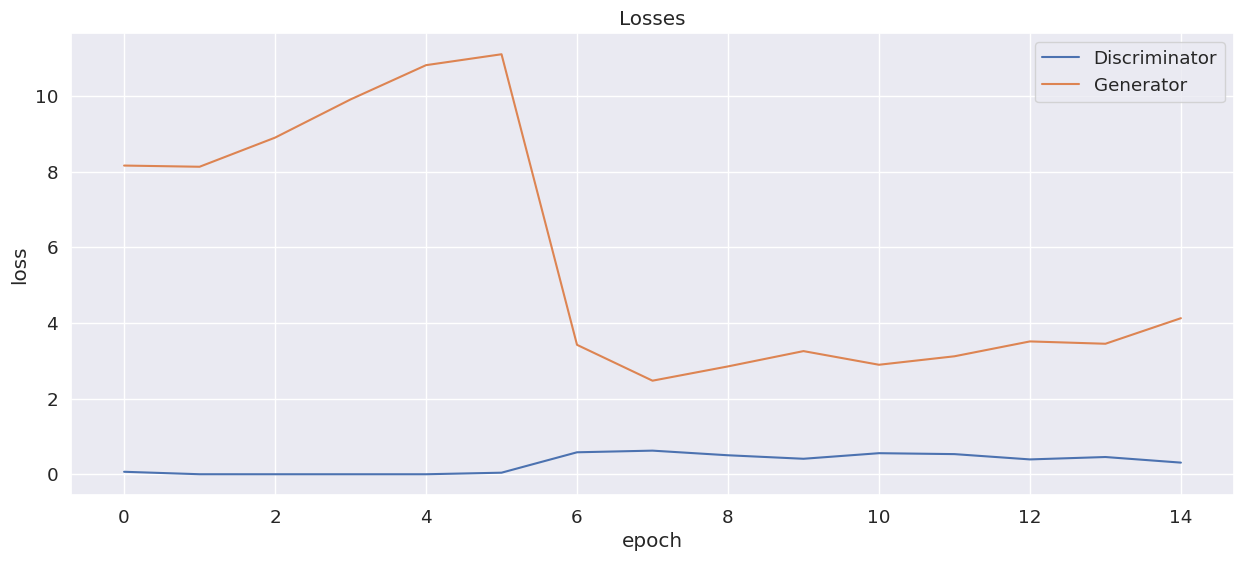

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

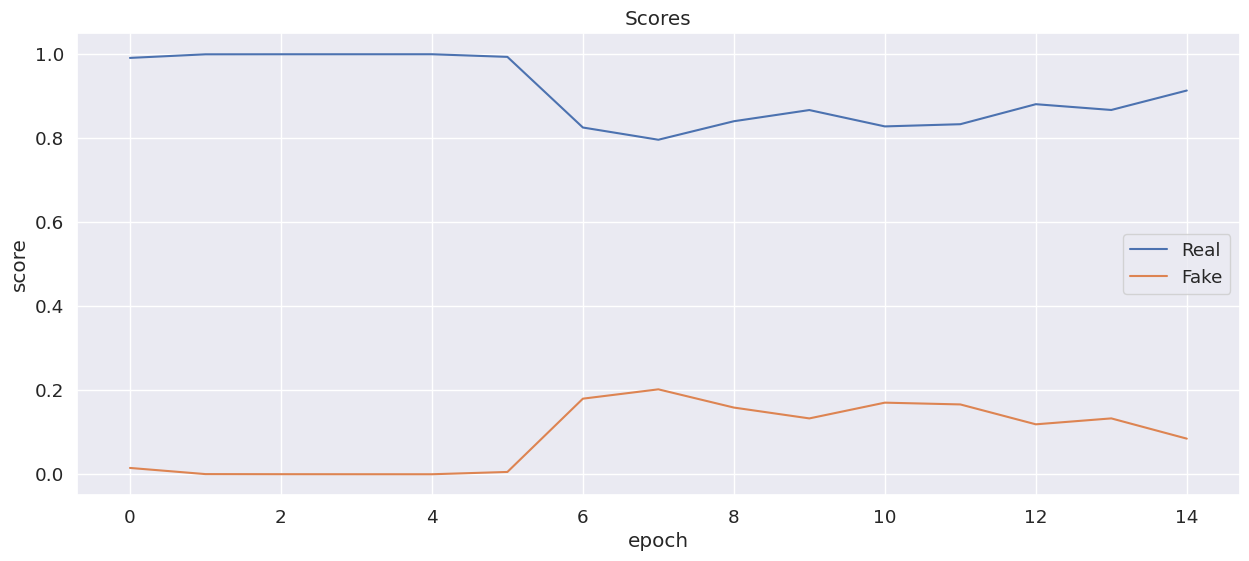

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');